In [1]:
#importing classes
import pandas as pd
import numpy as np
import pickle
import bilby as bi
from astropy import units as u
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.cosmology import Planck18,z_at_value
from scipy.optimize import curve_fit
from matplotlib import cm  # For color map
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import multiprocessing
from scipy.interpolate import interp1d
from concurrent.futures import ThreadPoolExecutor
import emcee
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
import matplotlib.cm as cm
from matplotlib import rc
import time
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation, FFMpegWriter
from collections import defaultdict
from scipy.stats import bootstrap
from scipy.ndimage import gaussian_filter1d
import corner
from scipy.stats import multivariate_normal
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from fit_H0 import *

## Create redshift interpolant

In [4]:
# Define grid ranges
H0_min, H0_max, H0_steps = 40, 100, 256  # H0 in km/s/Mpc
D_L_min, D_L_max, D_L_steps = 1, 1e6, 2500  # D_L in Mpc

H0_values = np.linspace(H0_min, H0_max, H0_steps)
D_L_values = np.linspace(D_L_min, D_L_max, D_L_steps)

z_grid = np.zeros((H0_steps, D_L_steps))

In [9]:
def compute_z(i, j):
    H0 = H0_values[i]
    D_L = D_L_values[j]

    try:
        cosmo = Planck18.clone(H0=H0 * u.km / (u.Mpc * u.s))
        z = z_at_value(cosmo.luminosity_distance, D_L * u.Mpc)
        
        return (i, j, z)
    except Exception as e:
        print(f"Warning: H0={H0}, D_L={D_L} — {e}")
        return (i, j, np.nan)

# Flatten the grid and compute in parallel
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(compute_z)(i, j)
    for i in range(len(H0_values))
    for j in range(len(D_L_values))
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 843 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1635 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3695 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 8000 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 12896 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 18368 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 24416 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 31040 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 38240 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 46016 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 54368 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 63296 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 72800 tasks      | elap

In [10]:
# Define ranges for H0 and redshift
H0_values = np.linspace(40, 100, 256)  # H0 in km/s/Mpc

for i, j, z in results:
    z_grid[i, j] = z.value  # Axis 0: H0, 1: D_L

# Create the interpolant
redshift_interpolant = RegularGridInterpolator(
    (H0_values, D_L_values),
    z_grid,
    bounds_error=False,
    fill_value=np.nan
)

In [13]:
""""

# Save the interpolant to a file
with open("redshift_interpolant.pkl", "wb") as f:
    pickle.dump(redshift_interpolant, f)

print("Interpolant saved to redshift_interpolant.pkl")
"""

'"\n\n# Save the interpolant to a file\nwith open("redshift_interpolant.pkl", "wb") as f:\n    pickle.dump(redshift_interpolant, f)\n\nprint("Interpolant saved to redshift_interpolant.pkl")\n'

In [2]:
with open("redshift_interpolant.pkl", "rb") as f:
    redshift_interpolant = pickle.load(f)

## Parameters to generate BBH mass distribution

In [3]:
# Parameters with astropy units
mu_1 = 10.0 * u.Msun
mu_2 = 33.4 * u.Msun
sigma_1 = 1.1 * u.Msun
sigma_2 = 4.2 * u.Msun
f_p1 = 0.75
f_p2 = 0.07

f_p1 = 0.75
f_p2 = 0.07

alpha_1 = -2.7
alpha_2 = -4.2
m_min = 12.9 * u.Msun
delta_m = 0.6 * u.Msun
m_b = 42.7 * u.Msun
m_max = 100 * u.Msun
num_samples = int(5e4)
k_1 = 0.0
k_2= 1
mass_error_fraction=0.1
log_distance_scatter=0.05

## Generate samples

In [4]:
# Simulations
redshifts = generate_redshift_samples(0.0, 10.0, num_samples)
p_values, mass = massDensity_evol(mu_1, sigma_1, f_p1, alpha_1, m_min, m_b, 
                                          mu_2, sigma_2, f_p2, alpha_2, delta_m, m_max, 
                                          redshifts, k_1, k_2)
cdf_list = [cumulativeDensity(p, mass) for p in p_values]
massSamples = inverseTransformSamplingWithEvolution(cdf_list, mass, redshifts, num_samples)
log_mass_plus_log1pz = np.log10(massSamples.value * (1 + redshifts))
        #luminosityDistances = luminosity_distance_interp(redshifts)
luminosityDistances = Planck18.luminosity_distance(redshifts).value

        # Add observational errors
luminosityDistances, log_mass_plus_log1pz = add_observational_error(
            luminosityDistances, log_mass_plus_log1pz, 
            mass_error_fraction=0, 
            log_distance_scatter=0
        )

## Data reduction / calibration

In [5]:
mask = np.where((luminosityDistances < 1e10) & (luminosityDistances > 0000))
filtered_luminosityDistances = luminosityDistances[mask]
filtered_log_mass_plus_log1pz = log_mass_plus_log1pz[mask]
filtered_redshifts = redshifts[mask]

## Fitting + Plotting

68.6111115798427
-0.006713172853280029
9.99619367532804
0.9515328745504555
32.300492602073916


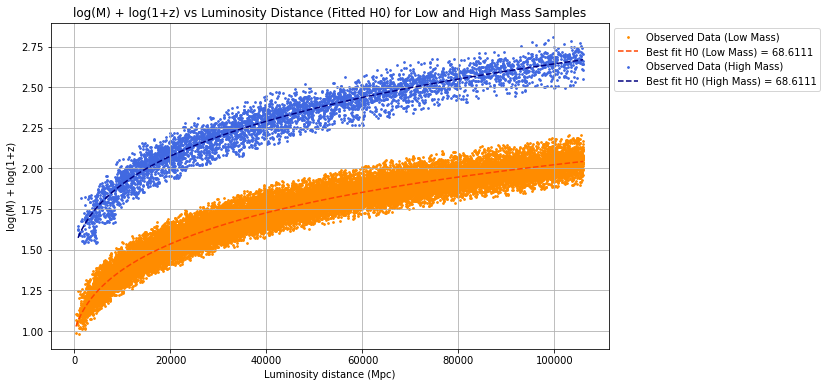

In [6]:
# Use the analyze_mass_distance_relation function and plot results
results, data_cut1, data_cut2 = analyze_mass_distance_relation_evol_iter_comb(
    filtered_luminosityDistances, filtered_log_mass_plus_log1pz,redshift_interpolant,d_num=100,width_fac=1.3
)

# Unpack the results
best_H0, best_mass_offset_low_mass,best_k_low_mass,best_mass_offset_high_mass,best_k_high_mass = results

luminosityDistances_cut1, log_mass_plus_log1pz_cut1 = data_cut1
luminosityDistances_cut2, log_mass_plus_log1pz_cut2 = data_cut2

print(best_H0)
print(best_k_low_mass)
print(best_mass_offset_low_mass)
print(best_k_high_mass)
print(best_mass_offset_high_mass)

# Plotting code
plt.figure(figsize=(10, 6))
fit_and_plot_evol(best_H0, best_mass_offset_low_mass,best_k_low_mass,luminosityDistances_cut1, log_mass_plus_log1pz_cut1, redshift_interpolant,"Low Mass", color_obs="darkorange", color_fit="orangered")
fit_and_plot_evol(best_H0, best_mass_offset_high_mass,best_k_high_mass,luminosityDistances_cut2, log_mass_plus_log1pz_cut2, redshift_interpolant,"High Mass", color_obs="royalblue", color_fit="navy")
plt.xlabel("Luminosity distance (Mpc)")
plt.ylabel("log(M) + log(1+z)")
plt.title("log(M) + log(1+z) vs Luminosity Distance (Fitted H0) for Low and High Mass Samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## Omega matter fitting

In [15]:
# Parameter grids
H0_values = np.linspace(40, 100, 60)
D_L_values = np.linspace(1, 1_000_000, 500)
omega_m_values = np.linspace(0.25, 0.35, 100)

# Preallocate output
z_grid_m = np.full((len(H0_values), len(D_L_values),len(omega_m_values)),0)

def compute_z(i, j, k):
    H0 = H0_values[i]
    D_L = D_L_values[j]
    Om0 = omega_m_values[k]

    try:
        cosmo = Planck18.clone(H0=H0 * u.km / (u.Mpc * u.s), Om0=Om0)
        z = z_at_value(cosmo.luminosity_distance, D_L * u.Mpc)
        
        return (i, j, k, z)
    except Exception as e:
        print(f"Warning: H0={H0}, Om0={Om0}, D_L={D_L} — {e}")
        return (i, j, k, np.nan)

# Flatten the grid and compute in parallel
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(compute_z)(i, j, k)
    for i in range(len(H0_values))
    for j in range(len(D_L_values))
    for k in range(len(omega_m_values))

)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3968 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5520 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 9344 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 15392 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 22016 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 29216 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 36992 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 45344 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 54272 tasks

In [11]:

for i, j, k, z in results:
    z_grid_m[i, j, k] = z.value  # Axis 0: H0, 1: D_L, 2: Om0

# Create the interpolant
redshift_interpolant_m = RegularGridInterpolator(
    (H0_values, D_L_values, omega_m_values),
    z_grid_m,
    bounds_error=False,
    fill_value=np.nan
)

# Save the interpolant to a file
with open("redshift_interpolant_m.pkl", "wb") as f:
    pickle.dump(redshift_interpolant_m, f)

print("Interpolant saved to redshift_interpolant_m.pkl")


Interpolant saved to redshift_interpolant_m.pkl


In [12]:

with open("redshift_interpolant_m.pkl", "rb") as f:
    redshift_interpolant_m = pickle.load(f)

## Parameters to generate BBH mass distribution

In [13]:
# Parameters with astropy units
mu_1 = 10.0 * u.Msun
mu_2 = 33.4 * u.Msun
sigma_1 = 1.1 * u.Msun
sigma_2 = 4.2 * u.Msun
f_p1 = 0.75
f_p2 = 0.07

f_p1 = 0.75
f_p2 = 0.07

alpha_1 = -2.7
alpha_2 = -4.2
m_min = 12.9 * u.Msun
delta_m = 0.6 * u.Msun
m_b = 42.7 * u.Msun
m_max = 100 * u.Msun
num_samples = int(5e4)
k_1 = 0.0
k_2= 1
mass_error_fraction=0.1
log_distance_scatter=0.05

## Generate samples

In [5]:
# Simulations
redshifts = generate_redshift_samples(0.0, 10.0, num_samples)
p_values, mass = massDensity_evol(mu_1, sigma_1, f_p1, alpha_1, m_min, m_b, 
                                          mu_2, sigma_2, f_p2, alpha_2, delta_m, m_max, 
                                          redshifts, k_1, k_2)
cdf_list = [cumulativeDensity(p, mass) for p in p_values]
massSamples = inverseTransformSamplingWithEvolution(cdf_list, mass, redshifts, num_samples)
log_mass_plus_log1pz = np.log10(massSamples.value * (1 + redshifts))
        #luminosityDistances = luminosity_distance_interp(redshifts)
luminosityDistances = Planck18.luminosity_distance(redshifts).value

        # Add observational errors
luminosityDistances, log_mass_plus_log1pz = add_observational_error(
            luminosityDistances, log_mass_plus_log1pz, 
            mass_error_fraction=0, 
            log_distance_scatter=0
        )

## Data reduction / calibration

In [6]:
mask = np.where((luminosityDistances < 1e10) & (luminosityDistances > 0000))
filtered_luminosityDistances = luminosityDistances[mask]
filtered_log_mass_plus_log1pz = log_mass_plus_log1pz[mask]
filtered_redshifts = redshifts[mask]

## Fitting + Plotting

100.0
-0.20272060622324015
9.729243303710932
-0.25253619504453967
32.82608728236156
0.3105945168326114


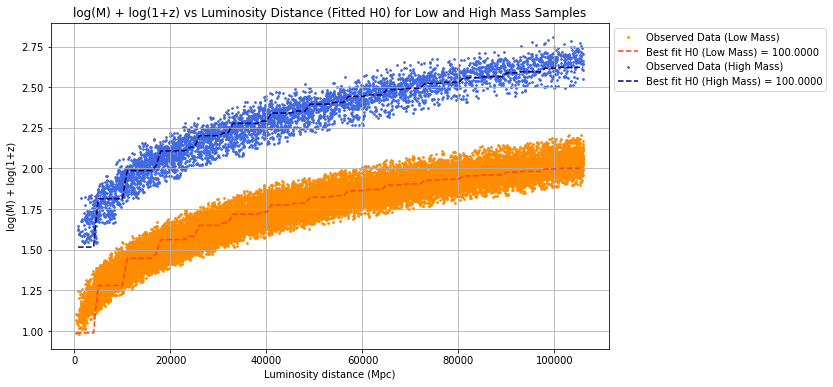

In [14]:
# Use the analyze_mass_distance_relation function and plot results
results, data_cut1, data_cut2 = analyze_mass_distance_relation_evol_iter_comb_m(
    filtered_luminosityDistances, filtered_log_mass_plus_log1pz,redshift_interpolant_m,d_num=100,width_fac=1.3)

# Unpack the results
best_H0, best_mass_offset_low_mass,best_k_low_mass,best_mass_offset_high_mass,best_k_high_mass,best_om_m = results

luminosityDistances_cut1, log_mass_plus_log1pz_cut1 = data_cut1
luminosityDistances_cut2, log_mass_plus_log1pz_cut2 = data_cut2

print(best_H0)
print(best_k_low_mass)
print(best_mass_offset_low_mass)
print(best_k_high_mass)
print(best_mass_offset_high_mass)
print(best_om_m)

# Plotting code
plt.figure(figsize=(10, 6))
fit_and_plot_evol_m(best_H0, best_mass_offset_low_mass,best_k_low_mass,best_om_m,luminosityDistances_cut1, log_mass_plus_log1pz_cut1, redshift_interpolant_m,"Low Mass", color_obs="darkorange", color_fit="orangered")
fit_and_plot_evol_m(best_H0, best_mass_offset_high_mass,best_k_high_mass,best_om_m,luminosityDistances_cut2, log_mass_plus_log1pz_cut2, redshift_interpolant_m,"High Mass", color_obs="royalblue", color_fit="navy")
plt.xlabel("Luminosity distance (Mpc)")
plt.ylabel("log(M) + log(1+z)")
plt.title("log(M) + log(1+z) vs Luminosity Distance (Fitted H0) for Low and High Mass Samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [221]:
# Prepare the input for the interpolant
points_low = np.vstack((
        np.full_like(luminosityDistances, 67.66),      # (N,) array of H0
        luminosityDistances,                     # (N,) array of distances
        np.full_like(luminosityDistances, 0.30966)    # (N,) array of Om_m
    )).T 

    # Get interpolated redshifts
redshifts_low = redshift_interpolant_m(points_low)

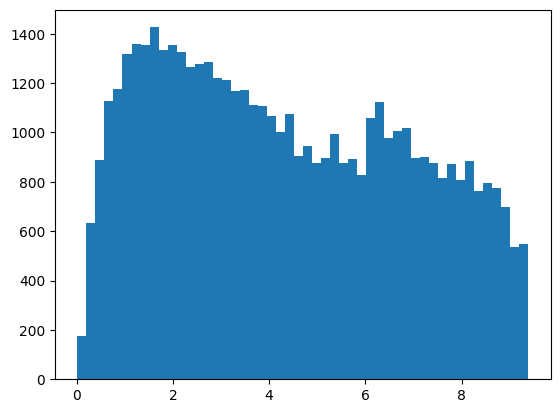

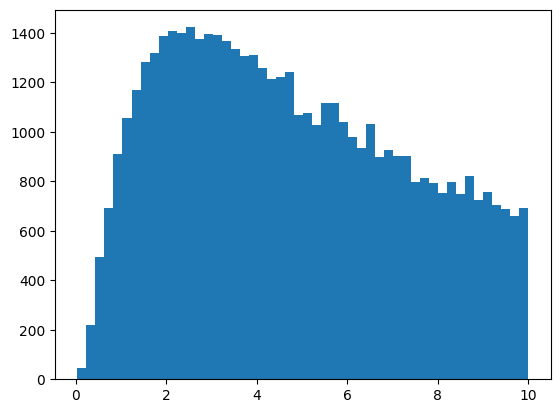

0.30966


In [223]:
plt.hist(redshifts_low,bins=50)
plt.show()
plt.hist(redshifts,bins=50)
plt.show()

print(Planck18.Om0)